In [10]:
#!jt -t chesterish -T -N -f roboto -fs 10
import numpy as np
import pandas as pd
import akshare as ak
from datetime import datetime as dt
from datetime import timedelta as td
import os
from enum import Enum
from typing import List
from vnpy.trader.object import BarData
from vnpy.trader.constant import Direction, Offset, Exchange, Interval
import vnpy_sqlite.sqlite_database as sqlite
class source(Enum):
    SINA = 'sina'
    RQ = 'rq'

In [11]:
#func and constants
src = source.SINA
freq = '1'
reFetch:bool = True
d_format = "%Y-%m-%d %H:%M:%S"
#fut_contract_path = r'C:\Users\lingy\git-repo\xtt\quantresearch\dataset\future_contract_hist'
#fut_info_path = r'C:\Users\lingy\git-repo\xtt\quantresearch\dataset\future_base_info\rq\futures_info_details.csv'
fut_contract_path = r'E:\dataset\future_contract_hist'
fut_info_path = r'E:\dataset\future_base_info\rq\futures_info_details.csv'

def fetch_contract_history(ticker:str, exch:str,\
                           freq:str = '1',\
                           src: source = source.SINA,\
                           refetch: bool = False,\
                           base_path:str = './/dataset//future_contract_hist'):
    filePath = os.path.join(base_path, src.value, freq, ticker + '.csv')
    ticker_pd = pd.DataFrame()
    if refetch: #only refetch from sina
        ticker_pd = ak.futures_zh_minute_sina(symbol=ticker, period=freq)
    else:
        ticker_pd = pd.read_csv(filePath)
    #augment df to fit vn bar object
    if src ==source.SINA:
        ticker_pd['order_book_id']=ticker
    #shift 1min back to fit vn convention
    ticker_pd['datetime'] = ticker_pd['datetime']\
    .apply(lambda r: dt.strftime(dt.strptime(r,d_format) - td(minutes = 1), d_format))
    ticker_pd['exchange'] = exch
    ticker_pd['gateway'] = src.value
    return ticker_pd
    
def push_db(bars:List[BarData]):
    sql_db = sqlite.SqliteDatabase()
    pushed = sql_db.save_bar_data(bars)
    closed = sql_db.db.close()
    return pushed,closed
def parseBar(row):
    return BarData(symbol = row['order_book_id'],\
                   exchange = Exchange(row['exchange']),\
                   datetime = dt.strptime(row['datetime'],d_format),\
                  volume = float(row['volume']),\
                  open_price = float(row['open']),\
                  high_price = float(row['high']),\
                  low_price = float(row['low']),\
                  close_price = float(row['close']),\
                  interval = Interval.MINUTE,\
                  gateway_name = row['gateway'])

In [7]:
#read leg A and B 1m history and load db
tickerA = 'IC2202'
tickerB = 'IC2203'
exch = 'CFFEX'
tickerA_df = fetch_contract_history(tickerA,exch,freq,src,reFetch,base_path = fut_contract_path)
tickerB_df = fetch_contract_history(tickerB,exch,freq,src,reFetch,base_path = fut_contract_path)
bar_A = tickerA_df.apply(parseBar,axis = 1).to_list()
bar_B = tickerB_df.apply(parseBar,axis = 1).to_list()
s,c = push_db(bar_A)
print("ticker {0} loaded to db:{1}; Count {2}; db closed:{3}".format(tickerA,s,len(bar_A),c))
s,c = push_db(bar_B)
print("ticker {0} loaded to db:{1}; Count {2}; db closed:{3}".format(tickerB,s,len(bar_B),c))

ticker IC2202 loaded to db:True; Count 3875; db closed:True
ticker IC2203 loaded to db:True; Count 3902; db closed:True


In [8]:
#check db load
end_date = dt.now()
days_delta = 20
start_date = end_date - td(days = days_delta)
sql_db = sqlite.SqliteDatabase()
bar_dt_load = sql_db.load_bar_data(symbol = tickerA, exchange = Exchange(exch), interval = Interval.MINUTE, start = start_date, end = end_date)
print("ticker A check: {0} (last {1} days)".format(len(bar_dt_load),days_delta))
bar_dt_load = sql_db.load_bar_data(symbol = tickerB, exchange = Exchange(exch), interval = Interval.MINUTE, start = start_date, end = end_date)
print("ticker B check: {0} (last {1} days)".format(len(bar_dt_load),days_delta))
sql_db.db.close()

ticker A check: 3382 (last 20 days)
ticker B check: 3386 (last 20 days)


True

<AxesSubplot:>

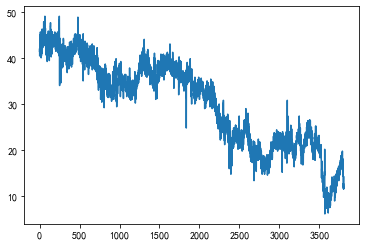

In [9]:
#spread quick check
merge_df = tickerA_df.merge(tickerB_df, left_on='datetime', right_on='datetime',
          suffixes=('_A', '_B'))
merge_df['datetime']=merge_df['datetime'].apply(lambda d:dt.strptime(d,d_format))
merge_df['spread_close']=merge_df['close_A'] - merge_df['close_B']
merge_df['spread_close'].plot()

In [10]:
bar_dt_load[-50:]

[BarData(gateway_name='DB', symbol='IC2203', exchange=<Exchange.CFFEX: 'CFFEX'>, datetime=datetime.datetime(2022, 1, 21, 14, 10, tzinfo=<DstTzInfo 'Asia/Shanghai' CST+8:00:00 STD>), interval=<Interval.MINUTE: '1m'>, volume=37.0, turnover=0.0, open_interest=0.0, open_price=6990.4, high_price=6993.0, low_price=6990.2, close_price=6992.8),
 BarData(gateway_name='DB', symbol='IC2203', exchange=<Exchange.CFFEX: 'CFFEX'>, datetime=datetime.datetime(2022, 1, 21, 14, 11, tzinfo=<DstTzInfo 'Asia/Shanghai' CST+8:00:00 STD>), interval=<Interval.MINUTE: '1m'>, volume=36.0, turnover=0.0, open_interest=0.0, open_price=6992.8, high_price=6993.2, low_price=6990.0, close_price=6990.0),
 BarData(gateway_name='DB', symbol='IC2203', exchange=<Exchange.CFFEX: 'CFFEX'>, datetime=datetime.datetime(2022, 1, 21, 14, 12, tzinfo=<DstTzInfo 'Asia/Shanghai' CST+8:00:00 STD>), interval=<Interval.MINUTE: '1m'>, volume=30.0, turnover=0.0, open_interest=0.0, open_price=6990.2, high_price=6991.6, low_price=6988.0, clos